<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Data-Analysis-Projects/blob/master/LA_Parking_Citation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LA Parking Citation Analysis

This dataset of parking citations for the city of Los Angeles. Parking citations with latitude / longitude (XY) in US Feet coordinates according to the NAD_1983_StatePlane_California_V_FIPS_0405_Feet projection.

### Analysis performed by:

Ken Wood

Senior Marketing Strategist

ken@roarmarketingconcepts.com




---



### Mount my Google Drive where the LA Parking Citation dataset is located...

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!apt install proj-bin libproj-dev libgeos-dev
!pip install git+https://github.com/thearn/pygmaps-extended
!pip install folium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
  Cloning https://github.com/thearn/pygmaps-extended to /tmp/pip-req-build-4f75815p
  Running setup.py bdist_wheel for pygmaps-enhanced ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-p0bd0zw8/wheels/3e/73/23/3a7fd54a762fa8d2305b95499c22de36c493fcfa63074cf397
Successfully built pygmaps-enhanced


In [0]:
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
!sudo pip install -U git+https://github.com/matplotlib/basemap.git

     | 165.5MB 20.8MB/s
  Running setup.py bdist_wheel for basemap ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1gs6145/wheels/6c/c2/bd/d6fb8f2660e0591d357352aba1b117b3211d016994d933d792
Successfully built basemap
  Found existing installation: basemap 1.2.0
    Uninstalling basemap-1.2.0:
      Successfully uninstalled basemap-1.2.0
  [mpl_toolkits]
You must restart the runtime in order to use newly installed versions.
  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-zawl7spz
  Running setup.py bdist_wheel for basemap ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1gn90jc/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
Successfully built basemap
  Found existing installation: basemap 1.1.0


### Install some necessary packages to perform the required analysis...

In [40]:
!pip install -U scikit-learn
!pip install --user --upgrade tables
!pip install utm

import pandas as pd
import numpy as np
import sklearn
import scipy
import calendar
import folium
from datetime import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
plt.rc("font", size=14)
from pylab import scatter, show, legend, xlabel, ylabel

from mpl_toolkits.basemap import Basemap

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.4.4)


In [0]:
"""width = 28000000; lon_0 = -105; lat_0 = 40
m = Basemap(width=width,height=width,projection='aeqd',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary(fill_color='aqua')
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='coral',lake_color='aqua')
# 20 degree graticule.
m.drawparallels(np.arange(-80,81,20))
m.drawmeridians(np.arange(-180,180,20))
# draw a black dot at the center.
xpt, ypt = m(lon_0, lat_0)
m.plot([xpt],[ypt],'ko')
# draw the title.
plt.title('Azimuthal Equidistant Projection')
plt.show()"""

"width = 28000000; lon_0 = -105; lat_0 = 40\nm = Basemap(width=width,height=width,projection='aeqd',\n            lat_0=lat_0,lon_0=lon_0)\n# fill background.\nm.drawmapboundary(fill_color='aqua')\n# draw coasts and fill continents.\nm.drawcoastlines(linewidth=0.5)\nm.fillcontinents(color='coral',lake_color='aqua')\n# 20 degree graticule.\nm.drawparallels(np.arange(-80,81,20))\nm.drawmeridians(np.arange(-180,180,20))\n# draw a black dot at the center.\nxpt, ypt = m(lon_0, lat_0)\nm.plot([xpt],[ypt],'ko')\n# draw the title.\nplt.title('Azimuthal Equidistant Projection')\nplt.show()"

In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Load the dataset...

In [42]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/LA Parking Citations/los-angeles-parking-citations/parking-citations.csv')
coordinates = pd.read_csv('/gdrive/My Drive/Colab Notebooks/LA Parking Citations/los-angeles-parking-citations/stateplane.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,HOND,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,GMC,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NISS,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,ACUR,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0


In [0]:
df.isnull().sum()

Ticket number                  0
Issue Date                   535
Issue time                  2590
Meter Id                 6472588
Marked Time              8456519
RP State Plate               765
Plate Expiry Date         797010
VIN                      8731405
Make                        8767
Body Style                  8898
Color                       4119
Location                     854
Route                      65389
Agency                       544
Violation code                 0
Violation Description        874
Fine amount                 6514
Latitude                       3
Longitude                      3
dtype: int64

### We drop the columns 'Meter Id', 'Marked Time', and 'VIN' since  most of their values are missing...

In [0]:
df.drop(['Meter Id','Marked Time','VIN'],axis=1,inplace=True)

### Let's convert all date fields to pandas 'datetime' variables so that we can easily work with dates and times in our analysis.

In [0]:
def CreateDateTimeVariable(column):
  column.fillna(0.0,inplace=True)
  column = column/100
  column = pd.to_datetime(column,format='%H.%M',errors = 'coerce').dt.time
  column = pd.to_datetime(column,format='%H:%M:%S').dt.time
  return column

In [0]:
df['Issue Date'] = pd.to_datetime(df['Issue Date'],format = '%Y-%m-%d')

df['Issue Date Month'] = df['Issue Date'].dt.month
month_dict = {1:"Jan",2:"Feb", 3:"Mar", 4:"Apr", 5:"May",6: "Jun", 7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
df['Issue Date Month Name'] = df['Issue Date Month'].map(month_dict)

df['Issue Date Day'] = df['Issue Date'].dt.day
df['Issue Date Day of Week'] = df['Issue Date'].dt.weekday_name
 
df['Issue time'] = CreateDateTimeVariable(df['Issue time'])

df['Plate Expiry Date'].fillna(value = 201812.0,inplace=True)
df['Plate Expiry Date'] = df['Plate Expiry Date']/100
number_dec = df['Plate Expiry Date']%1
number_dec.where(number_dec<=0.12,0.12)
df['Plate Expiry Date'] = df['Plate Expiry Date'].astype(np.int64) + number_dec
df['Plate Expiry Date'] = df['Plate Expiry Date'].astype(str)
df['Plate Expiry Date'] = pd.to_datetime(df['Plate Expiry Date'],format='%Y.%m',errors='coerce')

### Let's get a barchart of the number of tickets issued per month...




In [0]:
citations_per_month = df.groupby(df['Issue Date Month Name'])['Ticket number'].count().reset_index()
citations_per_month.rename(columns = {'Ticket number': 'Number of Tickets'},inplace=True)
citations_per_month

,Issue Date Month Name,Number of Tickets
0,Apr,732434
1,Aug,760805
2,Dec,723418
3,Feb,684398
4,Jan,807946
5,Jul,697655
6,Jun,743998
7,Mar,796876
8,May,753638
9,Nov,657713


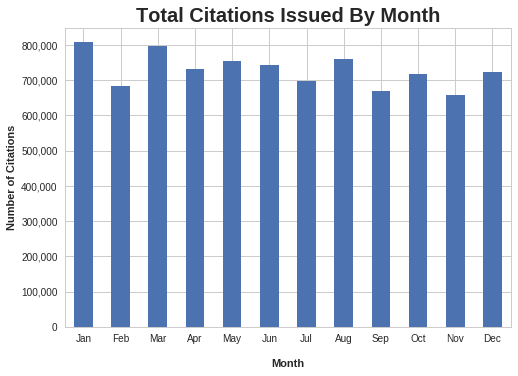

In [0]:
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax = citations_per_month.set_index("Issue Date Month Name").loc[month_order].plot(kind="bar", legend=False)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))   
ax.set_xlabel('Month',labelpad =15,fontweight='bold')
ax.set_ylabel('Number of Citations',fontweight='bold')
ax.set_title('Total Citations Issued By Month',fontsize=20,fontweight='bold')

plt.show()

### How many citations were issued for each day of the week?

In [0]:
citations_per_weekday = df.groupby(df['Issue Date Day of Week'])['Ticket number'].count().reset_index()
citations_per_weekday.rename(columns = {'Ticket number': 'Number of Tickets'},inplace=True)
citations_per_weekday

,Issue Date Day of Week,Number of Tickets
0,Friday,1424611
1,Monday,1427306
2,Saturday,492124
3,Sunday,446726
4,Thursday,1638213
5,Tuesday,1701473
6,Wednesday,1616726


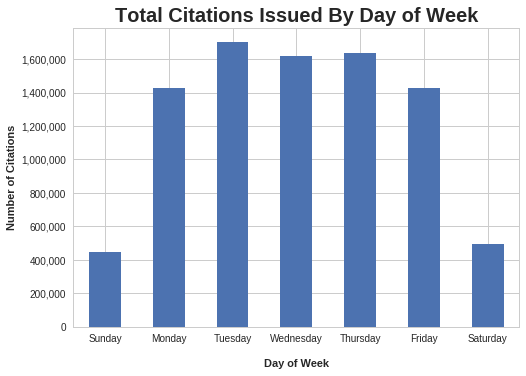

In [0]:
day_order = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
ax = citations_per_weekday.set_index("Issue Date Day of Week").loc[day_order].plot(kind="bar", legend=False)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))   
ax.set_xlabel('Day of Week',labelpad =15,fontweight='bold')
ax.set_ylabel('Number of Citations',fontweight='bold')
ax.set_title('Total Citations Issued By Day of Week',fontsize=20,fontweight='bold')

plt.show()

### Let's use the latitude and longitude info provided to produce a map showing where the citations were issued...

In [43]:
coordinates.describe()

,Unnamed: 0,Latitude,Longitude,Count,Lon,Lat
count,716326.000000,7.163260e+05,7.163260e+05,716326.000000,716326.000000,716326.000000
mean,358162.500000,6.463841e+06,1.854419e+06,10.390895,-118.345951,34.067521
std,206785.648801,4.933780e+06,4.940503e+06,71.531312,0.407241,0.232636
min,0.000000,6.275463e+06,1.582640e+06,1.000000,-118.944791,-89.977899
25%,179081.250000,6.433912e+06,1.829179e+06,1.000000,-118.421959,34.018197
50%,358162.500000,6.462764e+06,1.844984e+06,2.000000,-118.326637,34.061679
75%,537243.750000,6.478113e+06,1.867983e+06,6.000000,-118.275757,34.125056
max,716325.000000,4.042322e+09,4.042322e+09,9827.000000,118.515748,34.748181


In [0]:
df_lat_lng = df.filter(['Latitude','Longitude'], axis=1)
df_lat_lng = df_lat_lng[df_lat_lng.Latitude != 99999]   # Filter out erroneous and values
df_lat_lng = df_lat_lng.dropna()
df_lat_lng = df_lat_lng.groupby(['Latitude','Longitude']).size().reset_index()
df_lat_lng = coordinates.merge(df_lat_lng, how='left', on=['Latitude','Longitude'])
df_lat_lng = df_lat_lng.drop(['Unnamed: 0',0],axis=1)
df_lat_lng = df_lat_lng[df_lat_lng.Lat > 0]

In [0]:
lat = np.asarray(df_lat_lng['Lat'])
lng = np.asarray(df_lat_lng['Lon'])

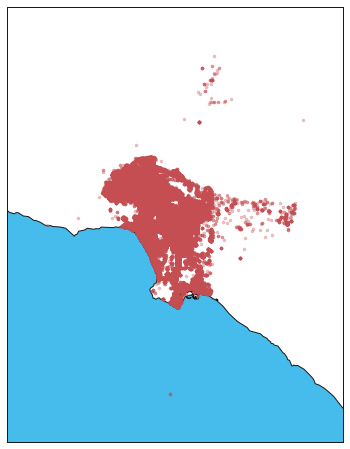

In [0]:
margin = 0.2                     # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lng_min = min(lng) - margin
lng_max = max(lng) + margin

# create map using BASEMAP
fig,ax = plt.subplots(figsize=(14,8))

map = Basemap(llcrnrlon=lng_min,
            llcrnrlat=lat_min,
            urcrnrlon=lng_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lng_max-lng_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.drawmapboundary(fill_color='#46bcec')
map.fillcontinents(color = 'white',lake_color='#46bcec')

# convert lat and long to map projection coordinates
x,y = map(lng, lat)

# plot points as red dots

map.scatter(x,y, marker = 'o',s = 10, color='r',alpha=0.35, zorder=10)

### Where are the citations with the largest fines located?

In [87]:
df_fine_analysis = df[['Longitude', 'Latitude','Fine amount']].copy()
df_fine_analysis = (df_fine_analysis[df_fine_analysis.Longitude != 99999]).dropna()
df_fine_analysis = df_fine_analysis.groupby(['Longitude','Latitude'])['Fine amount'].sum().reset_index()
df_fine_analysis.sort_values(by='Fine amount',ascending=False)

,Longitude,Latitude,Fine amount
815656,1.859071e+06,6.458312e+06,472781.0
185659,1.819688e+06,6.419829e+06,440233.0
815665,1.859071e+06,6.458312e+06,323561.0
944666,1.882602e+06,6.448999e+06,319278.0
660890,1.849114e+06,6.463690e+06,314947.0
803283,1.858225e+06,6.467525e+06,269764.0
383244,1.836302e+06,6.448021e+06,267095.0
660897,1.849114e+06,6.463690e+06,264928.0
383245,1.836302e+06,6.448021e+06,216188.0
951055,1.883364e+06,6.449000e+06,215117.0
